In [304]:
import pandas
#pandas.options.display.max_colwidth = None #set_option('max_colwidth', None)
#pandas.options.display.max_columns = 20#None#(100)#set_option('max_columns', None)

import numpy
import pygsheets
import datetime
import scipy
import sklearn.linear_model
import sklearn.cluster
import re

import matplotlib.pyplot as mp

# import pipelines dataset

In [305]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')

spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
#spreadsheet = gc.open_by_key('1PKsCoVnfnCEalDBOF0Fmny0-pg1qy86DoReNHI-97WM') # version from 6 March 2023 for EGT report

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = gas_pipes.copy()

# remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.PipelineName!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Wiki!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Fuel.isin(['Gas','Hydrogen'])]

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [306]:
country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--',numpy.nan,inplace=True)
pipes_df_orig['ProposalYear'] = pipes_df_orig['ProposalYear'].replace('',numpy.nan)
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [307]:
region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
region_df_egt = region_df_orig.copy()[region_df_orig['EuroGasTracker']=='Yes']
region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
region_df_eu_uk = region_df_orig.copy()[(region_df_orig['Region']=='Europe') | 
                                          (region_df_orig['Country'].isin(['United Kingdom','Israel']))]

In [308]:
region_df_touse = region_df_eu.copy()

In [309]:
# subset the pipelines to use
# can't use pipes_df_touse... because some of the pipelines get eliminated if they're not in the same country...
pipes_df_touse = pipes_df_orig.loc[
    ~pipes_df_orig['Countries'].apply(
        lambda x: set(x.split(', ')).isdisjoint(set(region_df_touse['Country'].tolist()))
    )]

pipes_df_touse_h2 = pipes_df_touse.loc[(pipes_df_touse.Fuel=='Hydrogen')|
                                       (pipes_df_touse.H2Status!='')]
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.Fuel=='Gas']
pipes_df_orig_gas = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')]
country_ratios_df_touse = country_ratios_df.loc[#(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
                                                (country_ratios_df.Fuel=='Gas')]

country_ratios_df_touse_eu27 = country_ratios_df.loc[(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
                                                (country_ratios_df.Fuel=='Gas')]

In [310]:
country_ratios_df_touse.shape

(4009, 36)

In [311]:
western_eu = ['Ireland', 'France', 'Belgium', 'Netherlands', 
              'Luxembourg', 'Germany', 'Austria'] 

eastern_eu = ['Estonia', 'Latvia', 'Lithuania', 'Poland', 'Czech Republic', 
              'Slovakia', 'Slovenia', 'Croatia', 'Hungary', 'Romania', 'Bulgaria'] 

southern_eu = ['Portugal', 'Spain', 'Italy', 
               'Malta', 'Greece', 'Cyprus']

northern_eu = ['Sweden', 'Finland', 'Denmark']

# cost estimates for EU 27 member states

## outliers and special cases

### correct Poland-Ukraine Interconnector

In [312]:
# https://www.gem.wiki/Poland-Ukraine_Interconnector_Gas_Pipeline
# our country_ratios code calculates this is half in each country, but it's not
country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_touse.Country=='Poland'),'MergedKmByCountry'] = 1.5

country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_touse.Country=='Ukraine'),'MergedKmByCountry'] = 99.0

### correct Gas Interconnection Poland-Lithuania (our fractional calc doesn't get it right)

In [313]:
country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_touse.Country=='Poland'),'MergedKmByCountry'] = 343.0

country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_touse.Country=='Lithuania'),'MergedKmByCountry'] = 165.0

## exploring alternative cost calculations

* if a given pipeline is super long and costs more than a short one per km, then should it be weighed more heavily in calculating the EU-average pipeline cost? the idea is that longer pipelines probably cost a significantly larger amount to build... look at the plot of that first perhaps

pipeline cost vs length?

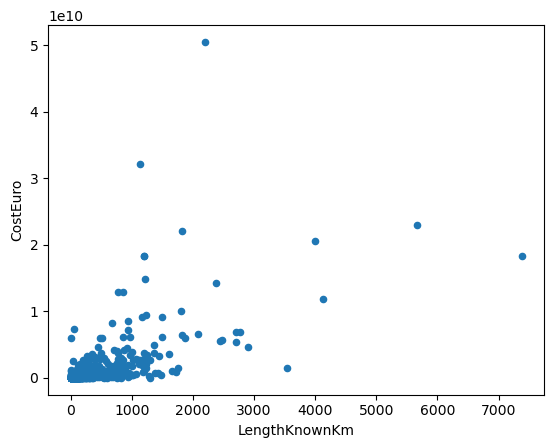

In [314]:
ax = pipes_df_orig.plot.scatter('LengthKnownKm','CostEuro')

### regression estimate: given length, estimate cost

In [315]:
pipes_df_toregress = pipes_df_touse.loc[(~pipes_df_touse.LengthKnownKm.isnull())&
                                       (~pipes_df_touse.CostEuro.isnull())&
                                       (pipes_df_touse.LengthKnownKm>0)]

# calculate projects with same name/cost, drop the first of the same pipeline names...
same_name_and_cost = pipes_df_toregress.loc[(pipes_df_toregress.duplicated('CostEuroPerKm'))&
                       (pipes_df_toregress.duplicated('PipelineName'))].drop_duplicates('PipelineName', keep='first')
pipes_df_toregress_dropdupes = pipes_df_toregress.drop(same_name_and_cost.index)

# # look at the full global dataset
# pipes_df_toregress = pipes_df_orig.loc[(~pipes_df_orig.LengthKnownKm.isnull())&
#                                         (~pipes_df_orig.CostEuro.isnull())&
#                                         (pipes_df_orig.LengthKnownKm!=0)]#&
#                                         #(pipes_df_orig.LengthKnownKm>100)&
#                                         #(pipes_df_orig.LengthKnownKm<1000)]

### gentle cluster analysis

In [316]:
num_clusters = 2
kmeans_cluster = sklearn.cluster.KMeans(n_clusters=num_clusters, 
                                        init='random', 
                                        n_init=10, 
                                        max_iter=300, 
                                        tol=1e-4,
                                       random_state=42)

km_fit = kmeans_cluster.fit_predict(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                   y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

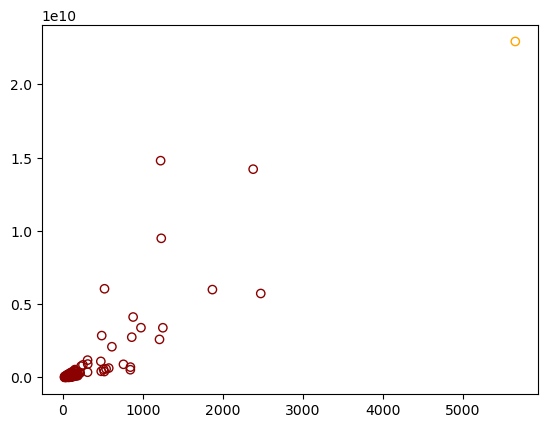

In [317]:
colors=['darkred','orange','green','blue','purple']

for i in range(num_clusters):
    mp.scatter(pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1)[km_fit == i],
               pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1)[km_fit == i],
               edgecolor=colors[i], color='None')

#mp.xlim(0,1000)
#mp.ylim(0,0.5e10)
# mp.scatter(pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1)[km_fit == 2],
#            pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1)[km_fit == 2],
#            color='slateblue', s=10)

In [318]:
ts_estimator = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                 y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

r_estimator = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

ols_estimator = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                  y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

ts_slope, ts_intercept, ts_low_slope, ts_high_slope = scipy.stats.mstats.theilslopes(y=pipes_df_toregress_dropdupes.CostEuro.tolist(), 
                                                                                     x=pipes_df_toregress_dropdupes.LengthKnownKm.tolist(),
                                                                                     alpha=0.1, )

s_slope, s_intercept = scipy.stats.mstats.siegelslopes(y=pipes_df_toregress_dropdupes.CostEuro.tolist(), 
                                                       x=pipes_df_toregress_dropdupes.LengthKnownKm.tolist())

/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[4.02061006]] OLS
[1.30434783] TS
[[0.99511391]] R
2.08789323164919 scipy TS slope
2.0434838816418948 straight-up mean


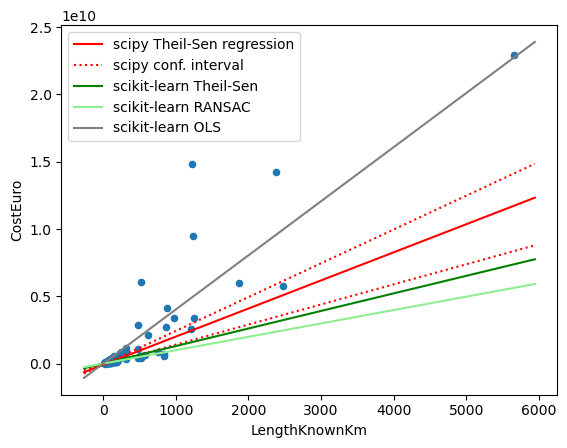

In [319]:
ax = pipes_df_toregress_dropdupes.plot.scatter('LengthKnownKm','CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred = ts_estimator.predict(xvals.reshape(-1,1))
r_pred = r_estimator.predict(xvals.reshape(-1,1))
ols_pred = ols_estimator.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope*xvals+ts_intercept, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope*xvals+ts_intercept, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope*xvals+ts_intercept, c='red', ls=':')

ax.plot(xvals, ts_pred, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred, label='scikit-learn OLS', c='gray')

ax.legend()

print(ols_estimator.coef_/1e6, "OLS")
print(ts_estimator.coef_/1e6, "TS")
print(r_estimator.estimator_.coef_/1e6, "R")
print(ts_slope/1e6, "scipy TS slope")
print(pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6, "straight-up mean")

## cost decision!

I'm going to use the full linear regression slope and the drop-duplicates average

### now use these country-specific costs as multipliers on within-country kilometers

LARGER MEAN

In [320]:
ols_estimator.coef_[0][0]/1e6

4.020610056100598

In [321]:
mean_cost_per_km = ols_estimator.coef_[0][0]/1e6

country_ratios_df_touse['TotalEstCostEuroMillionsHigh'] = numpy.nan

for idx,row in country_ratios_df_touse.iterrows():
    country_ratios_df_touse.loc[idx,'TotalEstCostEuroMillionsHigh'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_touse['CostEuroPerKm'].isna()
country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/2322650868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsHigh'] = numpy.nan


SMALLER MEAN

In [322]:
pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6

2.0434838816418948

In [323]:
mean_cost_per_km = pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6

country_ratios_df_touse['TotalEstCostEuroMillionsLow'] = numpy.nan

for idx,row in country_ratios_df_touse.iterrows():
    country_ratios_df_touse.loc[idx,'TotalEstCostEuroMillionsLow'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_touse['CostEuro'].isna()

country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']
country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']

country_ratios_df_touse.loc[(country_ratios_df_touse['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_touse['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_touse['Country']=='Italy'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

country_ratios_df_touse.loc[(country_ratios_df_touse['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_touse['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_touse['Country']=='Greece'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/275472991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsLow'] = numpy.nan


In [324]:
country_ratios_df_touse['TotalEstCostEuroMillionsMean'] = \
    country_ratios_df_touse[['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/1592955527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsMean'] = \


In [325]:
output_columns = ['Country',
                  'PipelineName',
                  'SegmentName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',
                  'TotalEstCostEuroMillionsLow',
                  'TotalEstCostEuroMillionsHigh']
country_ratios_df_touse_excel = country_ratios_df_touse[country_ratios_df_touse['Status'].isin(['Proposed','Construction'])]
country_ratios_df_touse_excel = country_ratios_df_touse.sort_values(['Status',
                                                                     'PipelineName',
                                                                     'TotalEstCostEuroMillionsLow',
                                                                     'TotalEstCostEuroMillionsHigh'],
                                                                    ascending=[True,True,False,False])
country_ratios_df_touse_excel.replace(numpy.nan, '')
country_ratios_df_touse_excel = country_ratios_df_touse_excel[output_columns]

## print export, import, and within-EU pipelines

planned pipelines to import gas into the EU

In [326]:
# get the pipelines that import into the EU, export out, and are completely within
pipes_df_eu_imports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (~pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_exports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (~pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_within = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

## Table A2

In [327]:
pipes_df_touse.loc[(pipes_df_touse.StartRegion!='Europe')&
                            (pipes_df_touse.EndRegion=='Europe')&
                            (pipes_df_touse.Status.isin(['Proposed','Construction']))].ProjectID

246     P0463
409     P0827
1754    P3203
1757    P3206
Name: ProjectID, dtype: object

In [242]:
# only construction, proposed project IDs here, built on a list:
import_projectids = [
'P0463', # Nigeria-Morocco Gas Pipeline (have in table, don't count it)
'P0479', # Israel Cyprus Gas Pipeline
#'P0684', # in 2022 (Baltic Pipe Project, now operating)
'P0702',
'P0732',
'P0827', # east med (have in table but don't count it)
'P3206', # east med expansion (have in table but don't count it)
'P1321',
'P1324',
#'P1773', # this is the Siret-Khotyn Gas Pipeline, doesn't count because Romania-Ukraine Interconnector already covers it
#'P2264',
'P3203', # Trans-Adriatic Gas Pipeline TAP Expansion, also P3204
#'P3204', # 0 new km
#'P3205', # 0 new km
#'P3281', # 0 new km
'P3335', # this is a duplicate of P2264
'P1773', # Romania-Ukraine Interconnector; this is a segment: Gheraesti-Siret Gas Pipeline (Ukraine to Romania, bidirectional), added manually
#'P3522', # UK-Ireland interconnector
'P4399'
]

all_other_projectids = list(set(country_ratios_df_touse.loc[
    country_ratios_df_touse.Status.isin(['Proposed','Construction'])].ProjectID) - set(import_projectids))

output_columns = ['Country',
                  'PipelineName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',]
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

country_ratios_df_touse.loc[(country_ratios_df_touse.ProjectID.isin(import_projectids))&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].sort_values(['Status','PipelineName',
                                                                                                   'TotalEstCostEuroMillionsLow'], 
                                                                                                  ascending=[True,True,False])[output_columns].replace(numpy.nan,'').style.hide(axis='index')


Country,PipelineName,Status,CapacityBcm/y,MergedKmByCountry,TotalEstCostEuroMillionsMean
Croatia,Bosnia and Herzegovina–Croatia South Interconnection Gas Pipeline,Proposed,1.500000,63.440000,41.373913
Cyprus,Cyprus-Turkey Gas Pipeline,Proposed,3.100000,48.110000,165.560823
Greece,East Med Gas Pipeline,Proposed,10.000000,1274.860000,4090.459893
Cyprus,East Med Gas Pipeline,Proposed,10.000000,569.350000,1826.791444
Cyprus,East Med Gas Pipeline,Proposed,10.000000,0.000000,
Greece,East Med Gas Pipeline,Proposed,10.000000,0.000000,
Croatia,Ionian Adriatic Gas Pipeline,Proposed,5.000000,262.010000,284.329372
Cyprus,Israel Cyprus Gas Pipeline,Proposed,4.000000,152.290000,227.443994
Spain,Nigeria-Morocco Gas Pipeline,Proposed,30.000000,137.850000,558.603754
Bulgaria,North Macedonia–Bulgaria Gas Pipeline,Proposed,2.060000,5.190000,1.085182


## Table A3 (appendix)

### longer than 150 km

In [243]:
# must be longer than 150 total, and the segment must be located within the EU
projectids_threshold = list(
    set(country_ratios_df_touse.loc[(country_ratios_df_touse.MergedKmByPipeline>150)&
                                   (country_ratios_df_touse.ProjectID.isin(all_other_projectids))&
                                   (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['ProjectID'])
)

projectids_under_threshold = list(
    set(all_other_projectids) - set(projectids_threshold)
)

projectids_threshold.__len__()

18

In [244]:
output_columns = ['Country',
                  'PipelineName',
                  #'Status',
                  'CapacityBcm/y',
                  'MergedKmByPipeline',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

country_ratios_df_touse.replace(numpy.nan,'').loc[
    (country_ratios_df_touse.ProjectID.isin(projectids_threshold))&
    (country_ratios_df_touse.Country.isin(region_df_touse.Country.tolist()))].sort_values([
    'Status','PipelineName','TotalEstCostEuroMillionsLow'], ascending=[True,True,False])[output_columns].style.hide(axis='index')


Country,PipelineName,CapacityBcm/y,MergedKmByPipeline,MergedKmByCountry,TotalEstCostEuroMillionsMean
Poland,Gustorzyn-Wronów Gas Pipeline,,308.000000,308.000000,933.870466
Italy,Methanization of Sardinia Project,,681.000000,681.000000,2064.823986
Italy,Methanization of Sardinia Project,,573.000000,573.000000,642.853210
Poland,Pogórska-Wola-Tworzen Gas Pipeline,,168.000000,168.000000,300.500001
Italy,Adriatica Pipeline,8.800000,170.000000,170.000000,553.600000
Romania,Black Sea Shore–Podișor Gas Pipeline,15.000000,308.000000,308.000000,360.000000
Cyprus,Cyprus–Egypt Gas Pipeline,8.000000,310.000000,32.950000,97.514057
Czech Republic,Czech-Polish Interconnector Gas Pipeline (CPI),,207.000000,155.340000,210.670176
Poland,Czech-Polish Interconnector Gas Pipeline (CPI),,207.000000,51.660000,70.060649
Croatia,Interconnector Croatia-Serbia,7.000000,182.000000,109.140000,93.308703


### shorter than 150 km

In [143]:
below_threshold_df = country_ratios_df_touse.loc[(country_ratios_df_touse.ProjectID.isin(projectids_under_threshold))&
                                                 (country_ratios_df_touse.Country.isin(region_df_touse.Country))]#.groupby('Status')

below_threshold_df.groupby('Status')[['MergedKmByCountry',
                                      'TotalEstCostEuroMillionsMean',
                                      'TotalEstCostEuroMillionsLow',
                                      'TotalEstCostEuroMillionsHigh']].sum()

,MergedKmByCountry,TotalEstCostEuroMillionsMean,TotalEstCostEuroMillionsLow,TotalEstCostEuroMillionsHigh
Status,,,,
Construction,401.2,683.320578,535.826965,830.814191
Proposed,3254.0,7151.641982,5861.784637,8441.499327


# import terminals now

In [280]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
#spreadsheet = gc.open_by_key('1BHiidrJnzh96Em3KrqBpCoWaJ3GB5OeCY9dHVaEDEFs') # mar 22 2022 version for EGT
#spreadsheet = gc.open_by_key('1d0kLE0WmAn9b4XdugffiEaAHGWy6EhyF7zY1DM12zCc') # 1 Mar 2023 version for EGT report

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A3')

In [281]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# only keep LNG terminals (remove oil)
terms_df_orig = terms_df_orig.loc[terms_df_orig.Fuel=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig.Wiki!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig.Status!='']

In [285]:
terms_df_touse = terms_df_orig.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))&
                                   (terms_df_orig.Fuel=='LNG')]
terms_df_touse_imports = terms_df_touse.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))&
                                            (terms_df_touse['FacilityType']=='Import')]

In [286]:
terms_df_touse_imports.loc[terms_df_touse_imports.Status.isin(['Proposed','Construction'])].shape

(44, 98)

#### pull out what to regress for costs

In [287]:
terms_df_floating_toregress = terms_df_touse.loc[(terms_df_touse['FacilityType']=='Import')&
                                                 (terms_df_touse.Floating=='yes')&
                                                 (~terms_df_touse['CostEuroPerBcm/y'].isnull())]
terms_df_floating_toregress_dropdupes = terms_df_floating_toregress.drop_duplicates('CostEuroPerBcm/y')

In [288]:
terms_df_onshore_toregress = terms_df_touse.loc[(terms_df_touse['FacilityType']=='Import')&
                                                (terms_df_touse.Floating=='')&
                                                (~terms_df_touse['CostEuroPerBcm/y'].isnull())&
                                                (~terms_df_touse.UnitName.str.contains('expansion', flags=re.IGNORECASE, regex=True))]
terms_df_onshore_toregress_dropdupes = terms_df_onshore_toregress.drop_duplicates('CostEuroPerBcm/y')

### regressions for costs

#### floating terminals

In [289]:
ts_estimator_f = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                 y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

r_estimator_f = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

ols_estimator_f = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                  y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

ts_slope_f, ts_intercept_f, ts_low_slope_f, ts_high_slope_f = scipy.stats.mstats.theilslopes(y=terms_df_floating_toregress.CostEuro.tolist(), 
                                                                            x=terms_df_floating_toregress['CapacityInBcm/y'].tolist(),
                                                                            alpha=0.1, )

s_slope_f, s_intercept_f = scipy.stats.mstats.siegelslopes(y=terms_df_floating_toregress.CostEuro.tolist(), 
                                                       x=terms_df_floating_toregress['CapacityInBcm/y'].tolist())

/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[69.48096476]] OLS
[65.45454545] TS
[[61.04220424]] R
48.13516876804125 scipy TS slope
118.55398874222223 straight-up mean


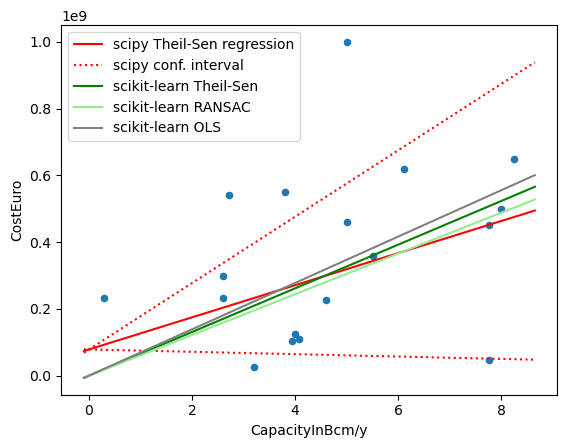

In [290]:
ax = terms_df_floating_toregress_dropdupes.plot.scatter('CapacityInBcm/y', 'CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred_f = ts_estimator_f.predict(xvals.reshape(-1,1))
r_pred_f = r_estimator_f.predict(xvals.reshape(-1,1))
ols_pred_f = ols_estimator_f.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope_f*xvals+ts_intercept_f, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope_f*xvals+ts_intercept_f, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope_f*xvals+ts_intercept_f, c='red', ls=':')

ax.plot(xvals, ts_pred_f, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred_f, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred_f, label='scikit-learn OLS', c='gray')

#ax.plot(

#ax.plot(xvals, s_slope*xvals+s_intercept, label = 'scipy.stats', c='orange')

ax.legend()

print(ols_estimator_f.coef_/1e6, "OLS")
print(ts_estimator_f.coef_/1e6, "TS")
print(r_estimator_f.estimator_.coef_/1e6, "R")
print(ts_slope_f/1e6, "scipy TS slope")
print(terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6, "straight-up mean")

#### onshore terminals

In [291]:
ts_estimator_o = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                 y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

r_estimator_o = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

ols_estimator_o = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                  y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

ts_slope_o, ts_intercept_o, ts_low_slope_o, ts_high_slope_o = scipy.stats.mstats.theilslopes(y=terms_df_onshore_toregress.CostEuro.tolist(), 
                                                                            x=terms_df_onshore_toregress['CapacityInBcm/y'].tolist(),
                                                                            alpha=0.1, )

s_slope_o, s_intercept_o = scipy.stats.mstats.siegelslopes(y=terms_df_onshore_toregress.CostEuro.tolist(), 
                                                       x=terms_df_onshore_toregress['CapacityInBcm/y'].tolist())

/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[97.91380559]] OLS
[141.48148148] TS
[[81.06155683]] R
87.71929824561404 scipy TS slope


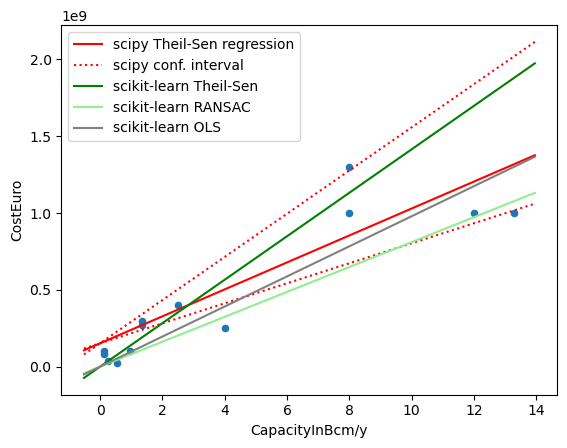

In [292]:
ax = terms_df_onshore_toregress_dropdupes.plot.scatter('CapacityInBcm/y', 'CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred_o = ts_estimator_o.predict(xvals.reshape(-1,1))
r_pred_o = r_estimator_o.predict(xvals.reshape(-1,1))
ols_pred_o = ols_estimator_o.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope_o*xvals+ts_intercept_o, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope_o*xvals+ts_intercept_o, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope_o*xvals+ts_intercept_o, c='red', ls=':')

ax.plot(xvals, ts_pred_o, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred_o, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred_o, label='scikit-learn OLS', c='gray')

#ax.plot(

#ax.plot(xvals, s_slope*xvals+s_intercept, label = 'scipy.stats', c='orange')

ax.legend()

print(ols_estimator_o.coef_/1e6, "OLS")
print(ts_estimator_o.coef_/1e6, "TS")
print(r_estimator_o.estimator_.coef_/1e6, "R")
print(ts_slope_o/1e6, "scipy TS slope")

In [293]:
terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

118.55398874222223

In [294]:
terms_df_onshore_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

208.35394516538463

## calculate floating costs (high and low estimates)

SMALLER MEAN

In [295]:
print(ols_estimator_f.coef_[0][0]/1e6)
print(ols_estimator_o.coef_[0][0]/1e6)

69.48096476196638
97.91380559055825


In [296]:
mean_cost_per_bcmy_floating = ols_estimator_f.coef_[0][0]/1e6
mean_cost_per_bcmy_onshore = ols_estimator_o.coef_[0][0]/1e6

terms_df_eu27_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
                                                 (terms_df_touse['FacilityType']=='Import')]

# do for floating
terms_df_eu27_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan

terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_eu27_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_eu27_import_future['CostEuro'].isna()
terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    terms_df_eu27_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/2114583819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan


LARGER MEAN

In [297]:
mean_cost_per_bcmy_floating = terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6
mean_cost_per_bcmy_onshore = terms_df_onshore_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

# terms_df_eu27_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
#                                                  (terms_df_touse['FacilityType']=='Import')]

# do for floating
terms_df_eu27_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan

terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_eu27_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_eu27_import_future['CostEuro'].isna()
terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    terms_df_eu27_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/2997317716.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan


In [298]:
terms_df_eu27_import_future['TotalEstCostEuroMillionsMean'] = \
    terms_df_eu27_import_future[['TotalEstCostEuroMillionsLow', 'TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/4095347764.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  terms_df_eu27_import_future['TotalEstCostEuroMillionsMean'] = \
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/4095347764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsMean'] = \


### correct outliers/special cases

In [299]:
# Zeebrugge terminal is 116 million for BOTH expansion projects, so set one equal to zero so it's not counted twice
#T042601	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2024 Expansion
#T042602	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2026 Expansion
outliers_comboids = ['T042602']
terms_df_eu27_import_future.loc[
    terms_df_eu27_import_future.ComboID.isin(outliers_comboids),
    ['TotalEstCostEuroMillionsMean','TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = 0.0

# Table A1

In [300]:
terms_df_eu27_import_future['CapacityInBcm/y'].sum()

223.93

In [303]:
output_columns = ['Country',
                  #'TerminalName',
                  'TerminalNameUnitName',
                  #'UnitName',
                  'CapacityInBcm/y',
                  #'Status',
                  #'FacilityType',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

terms_df_eu27_import_future['TerminalNameUnitName'] = (terms_df_eu27_import_future.TerminalName + ' ' + terms_df_eu27_import_future.UnitName).str.strip()
terms_df_eu27_import_future.sort_values(['Status','TerminalNameUnitName'],
                                        ascending=[True,True])[output_columns].replace(numpy.nan,'').style.hide(axis='index')

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/2303844954.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TerminalNameUnitName'] = (terms_df_eu27_import_future.TerminalName + ' ' + terms_df_eu27_import_future.UnitName).str.strip()


Country,TerminalNameUnitName,CapacityInBcm/y,TotalEstCostEuroMillionsMean
Greece,Alexandroupolis FSRU,5.500000,360.000000
Germany,Brunsbüttel LNG Terminal,8.000000,1300.000000
Cyprus,Cyprus LNG Terminal,2.720000,542.000000
Netherlands,Gate LNG Terminal Expansion,4.000000,350.000000
Estonia,Paldiski FSRU,,500.000000
Germany,Stade FSRU,6.000000,564.104861
Germany,Wilhelmshaven TES FSRU,5.000000,470.087384
Belgium,Zeebrugge LNG Terminal 2024 Expansion,6.390000,116.000000
Belgium,Zeebrugge LNG Terminal 2026 Expansion,1.770000,0.000000
Poland,Świnoujście Polskie LNG Terminal Expansion 2,2.100000,321.581138


# creating table 3 - future gas infra in EU countries

In [163]:
terms_df_eu27_import_future.groupby('Country')[['TotalEstCostEuroMillionsMean']].sum()

,TotalEstCostEuroMillionsMean
Country,
Belgium,116.0
Croatia,576.674463
Cyprus,337.0
Estonia,1150.0
France,2447.708254
Germany,6790.674505
Greece,2311.583415
Ireland,854.907658
Italy,4375.933977


In [164]:
terms_df_orig.loc[(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Status!='Cancelled')]['CapacityInBcm/y'].sum()

188.97000000000003

In [165]:
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.EuroCrisisTracker=='yes']['CapacityInBcm/y'].sum()

147.48

In [166]:
# table 1 shows country totals of pipeline length, cost, LNG capacity, cost, total cost
table2_columns = ['PipelineLengthKm','PipelineCostMillionEuro',
                  'LNGImportCapacityBcm/y','LNGTerminalCostMillionEuro','TotalCostMillionEuro']
table2_df = pandas.DataFrame(columns=table2_columns, index=region_df_touse.Country.tolist())

table2_df['PipelineLengthKm'] = country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['MergedKmByCountry'].sum()

table2_df['PipelineCostMillionEuro'] = country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['TotalEstCostEuroMillionsMean'].sum()

# add half of Trans-Adriatic expansion to Italy, half to Greece
#table2_df.loc['Greece','PipelineCostMillionEuro']+=1035/2
#table2_df.loc['Italy','PipelineCostMillionEuro']+=1035/2

table2_df['LNGImportCapacityBcm/y'] = terms_df_eu27_import_future.groupby('Country')['CapacityInBcm/y'].sum()
table2_df['LNGTerminalCostMillionEuro'] = terms_df_eu27_import_future.groupby('Country')['TotalEstCostEuroMillionsMean'].sum()
table2_df['TotalCostMillionEuro'] = table2_df.loc[:,('PipelineCostMillionEuro','LNGTerminalCostMillionEuro')].sum(axis=1)

if 'Total' in table2_df.index:
    table2_df.drop(index='Total', inplace=True)   
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df.loc['Total'] = total

else:
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df.loc['Total'] = total

# replace NaN with ''
table2_df.replace(numpy.nan, '', inplace=True)
table2_df.replace(0.0, '', inplace=True)

In [167]:
table2_df#['LNGImportCapacityBcm/y'][:-1].replace('',numpy.nan).sum()

,PipelineLengthKm,PipelineCostMillionEuro,LNGImportCapacityBcm/y,LNGTerminalCostMillionEuro,TotalCostMillionEuro
Cyprus,921.15,2685.641964,0.82,337.0,3022.641964
Austria,118.78,360.146539,,,360.146539
Belgium,147.89,448.409426,8.16,116.0,564.409426
Bulgaria,565.04,1434.548477,,,1434.548477
Czech Republic,157.95,218.583818,,,218.583818
Germany,841.13,2464.192649,74.3,6790.674505,9254.867153
Denmark,,,,,
Spain,522.85,1725.941837,8.0,1133.021015,2858.962852
Estonia,1.2,3.638456,6.17,1150.0,1153.638456
Finland,,,,,


# creating table 4 from report (nsew_eu)

In [168]:
import_projectids

['P0463',
 'P0479',
 'P0702',
 'P0732',
 'P0827',
 'P3206',
 'P1321',
 'P1324',
 'P3203',
 'P3335',
 'P1773',
 'P4399']

In [169]:
pipes_df_orig_gas.loc[pipes_df_orig_gas.ProjectID.isin(import_projectids)][['PipelineName','Wiki']]

,PipelineName,Wiki
246,Nigeria-Morocco Gas Pipeline,https://www.gem.wiki/Nigeria-Morocco_Gas_Pipeline
260,Israel Cyprus Gas Pipeline,https://www.gem.wiki/Israel_Cyprus_Gas_Pipeline
324,Ionian Adriatic Gas Pipeline,https://www.gem.wiki/Ionian_Adriatic_Gas_Pipeline
353,White Stream Gas Pipeline,https://www.gem.wiki/White_Stream_Gas_Pipeline
413,EastMed Gas Pipeline,https://www.gem.wiki/EastMed_Gas_Pipeline
774,Bosnia and Herzegovina–Croatia South Interconn...,https://www.gem.wiki/Bosnia_and_Herzegovina%E2...
775,Cyprus-Turkey Gas Pipeline,https://www.gem.wiki/Cyprus-Turkey_Gas_Pipeline
1758,Trans-Adriatic Gas Pipeline,https://www.gem.wiki/Trans-Adriatic_Gas_Pipeline
1761,EastMed Gas Pipeline,https://www.gem.wiki/EastMed_Gas_Pipeline
1805,North Macedonia–Bulgaria Gas Pipeline,https://www.gem.wiki/North_Macedonia%E2%80%93B...


In [170]:
region_list = [western_eu,eastern_eu,southern_eu,northern_eu]
index_list = ['Western EU','Eastern EU','Southern EU','Northern EU']
project_list = []

table4_nsew = pandas.DataFrame(0, columns=['EstCostMillionEuroConstruction',
                                           'CostNumPipesConstruction',
                                           'CostNumTermsConstruction',
                                           'PipeLengthConstruction',
                                           
                                        'CapacityInBcm/yConstruction',
                                           'CapacNumPipesConstruction',
                                           'CapacNumTermsConstruction',
                                           'CapacPipesConstruction',
                                           'CapacTermsConstruction',
                                           'PipesProjectIDsConstruction',
                                           'TermsComboIDsConstruction',
                                           
                                        'EstCostMillionEuroProposed',
                                           'CostNumPipesProposed',
                                           'CostNumTermsProposed',
                                           'PipeLengthProposed',
                                           
                                        'CapacityInBcm/yProposed',
                                           'CapacNumPipesProposed',
                                           'CapacNumTermsProposed',
                                           'CapacPipesProposed',
                                           'CapacTermsProposed'
                                           'PipesProjectIDsProposed',
                                           'TermsComboIDsProposed',
                                           
                                          ], index=range(4))

terms_w_eu = pandas.DataFrame()
terms_n_eu = pandas.DataFrame()
terms_s_eu = pandas.DataFrame()
terms_e_eu = pandas.DataFrame()

pipes_w_eu = pandas.DataFrame()
pipes_n_eu = pandas.DataFrame()
pipes_s_eu = pandas.DataFrame()
pipes_e_eu = pandas.DataFrame()

for idx,row in table4_nsew.iterrows():
    
    for STATUS in ['Proposed','Construction']:
        
        # for proposed
        # for pipeline costs, we don't care about imports only, we also care about general pipelines
        pipeline_cost = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))]['TotalEstCostEuroMillionsMean'].sum()
        
        pipe_cost_num = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))].ProjectID.unique().size
        
        pipe_length = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))]['MergedKmByCountry'].sum()

        pipeline_capacity = pipes_df_orig_gas.loc[(pipes_df_orig_gas.ProjectID.isin(import_projectids)) &
                                (pipes_df_orig_gas.EndCountry.isin(region_list[idx])) &
                                (pipes_df_orig_gas.Status.isin([STATUS]))]['CapacityBcm/y'].sum()
        
        pipe_cap_num = pipes_df_orig_gas.loc[(pipes_df_orig_gas.ProjectID.isin(import_projectids)) &
                                (pipes_df_orig_gas.EndCountry.isin(region_list[idx])) &
                                (pipes_df_orig_gas.Status.isin([STATUS]))]['CapacityBcm/y'].count()
        
        pipe_projectids = pipes_df_orig_gas.loc[(pipes_df_orig_gas.ProjectID.isin(import_projectids)) &
                                (pipes_df_orig_gas.EndCountry.isin(region_list[idx])) &
                                (pipes_df_orig_gas.Status.isin([STATUS]))].PipelineName.tolist()
        
        # ****************************************

        terminal_cost = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['TotalEstCostEuroMillionsMean'].sum()
        term_num = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['TerminalName'].count()

        terminal_capacity = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['CapacityInBcm/y'].sum()
        term_comboids = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))].TerminalName.tolist()

        # pipelines are import only
        which_pipelines_df = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]) &
                               (country_ratios_df_touse.ProjectID.isin(import_projectids)))]
        which_terminals_df = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]
        
        #print(which_terminals_df.ComboID)

        if index_list[idx]=='Western EU':
            terms_w_eu = pandas.concat([terms_w_eu,which_terminals_df])
            pipes_w_eu = pandas.concat([pipes_w_eu,which_pipelines_df])
        if index_list[idx]=='Northern EU':
            terms_n_eu = pandas.concat([terms_n_eu,which_terminals_df])
            pipes_n_eu = pandas.concat([pipes_n_eu,which_pipelines_df])
        if index_list[idx]=='Eastern EU':
            terms_e_eu = pandas.concat([terms_e_eu,which_terminals_df])
            pipes_e_eu = pandas.concat([pipes_e_eu,which_pipelines_df])
        if index_list[idx]=='Southern EU':
            terms_s_eu = pandas.concat([terms_s_eu,which_terminals_df])
            pipes_s_eu = pandas.concat([pipes_s_eu,which_pipelines_df])

        table4_nsew.loc[idx, 'EstCostMillionEuro'+STATUS] += terminal_cost+pipeline_cost
        table4_nsew.loc[idx, 'CapacityInBcm/y'+STATUS] += terminal_capacity+pipeline_capacity
        table4_nsew.loc[idx, 'CapacTerms'+STATUS] = terminal_capacity
        table4_nsew.loc[idx, 'CapacPipes'+STATUS] = pipeline_capacity
        table4_nsew.loc[idx, 'CostNumTerms'+STATUS] = term_num
        table4_nsew.loc[idx, 'CapacNumTerms'+STATUS] = term_num
        table4_nsew.loc[idx, 'CostNumPipes'+STATUS] = pipe_cost_num
        table4_nsew.loc[idx, 'CapacNumPipes'+STATUS] = pipe_cap_num
        table4_nsew.loc[idx, 'PipeLength'+STATUS] = pipe_length
        table4_nsew.loc[idx, 'PipesProjectIDs'+STATUS] = '\n'.join(pipe_projectids)
        table4_nsew.loc[idx, 'TermsComboIDs'+STATUS] = '\n'.join(term_comboids)

table4_nsew.index = index_list

# add trans-adriatic
#table4_nsew.loc['Southern EU','EstCostMillionEuroProposed'] += 1035.

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/2992756305.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13947.376247443754' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table4_nsew.loc[idx, 'EstCostMillionEuro'+STATUS] += terminal_cost+pipeline_cost
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/2992756305.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '107.62' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  table4_nsew.loc[idx, 'CapacityInBcm/y'+STATUS] += terminal_capacity+pipeline_capacity
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_70485/2992756305.py:112: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1112.69' has dtype in

In [171]:
pandas.options.display.max_columns=None

In [172]:
table4_nsew

,EstCostMillionEuroConstruction,CostNumPipesConstruction,CostNumTermsConstruction,PipeLengthConstruction,CapacityInBcm/yConstruction,CapacNumPipesConstruction,CapacNumTermsConstruction,CapacPipesConstruction,CapacTermsConstruction,PipesProjectIDsConstruction,TermsComboIDsConstruction,EstCostMillionEuroProposed,CostNumPipesProposed,CostNumTermsProposed,PipeLengthProposed,CapacityInBcm/yProposed,CapacNumPipesProposed,CapacNumTermsProposed,CapacPipesProposed,CapacTermsProposedPipesProjectIDsProposed,TermsComboIDsProposed,CapacTermsProposed,PipesProjectIDsProposed
Western EU,758.681039,2,3,82.0,13.16,0,3,0,13.16,,Zeebrugge LNG Terminal\nZeebrugge LNG Terminal...,13947.376247,17,18,1112.69,107.62,0,18,0.00,0,Dunkirk LNG Terminal\nFos Cavaou LNG Terminal\...,107.62,
Eastern EU,2076.366110,10,2,604.2,2.10,0,2,0,2.10,,Świnoujście Polskie LNG Terminal\nPaldiski FSRU,7795.852058,45,8,3752.85,46.02,5,8,13.37,0,Krk FSRU\nKrk FSRU\nPaldiski LNG Terminal\nTal...,32.65,Ionian Adriatic Gas Pipeline\nBosnia and Herze...
Southern EU,3794.792295,5,2,1445.0,6.32,0,2,0,6.32,,Cyprus LNG Terminal\nAlexandroupolis FSRU,24680.117880,29,12,5345.66,132.45,6,12,67.10,0,Gioia Tauro LNG Terminal\nToscana FSRU\nPorto ...,65.35,Nigeria-Morocco Gas Pipeline\nIsrael Cyprus Ga...
Northern EU,0.000000,0,0,0.0,0.00,0,0,0,0.00,,,0.000000,0,0,0.00,0.00,0,0,0.00,0,,0.00,


# creating figure 1 data

sum of Table 1 columns...

In [173]:
figure1_table_columns = ['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro','Total']
figure1_table_df = pandas.DataFrame(0, columns=figure1_table_columns, index=region_df_touse.Country,)


# for proposed
figure1_table_df['TotalProposedCostMillionEuro'] = \
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalProposedCostMillionEuro'] = \
figure1_table_df['TotalProposedCostMillionEuro'].add( \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                    fill_value=0)

#figure1_table_df.loc['Italy','TotalProposedCostMillionEuro'] += 1035/2.
#figure1_table_df.loc['Greece','TotalProposedCostMillionEuro'] += 1035/2.

# for construction
figure1_table_df['TotalConstructionCostMillionEuro'] = \
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalConstructionCostMillionEuro'] = \
figure1_table_df['TotalConstructionCostMillionEuro'].add( \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                         fill_value=0, axis=0)

figure1_table_df['Total'] = \
figure1_table_df[['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro']].sum(axis=1)
figure1_table_df.sort_values(['Total','Country'], ascending=[False, True], inplace=True)

figure1_table_df.replace(numpy.nan, '', inplace=True)
figure1_table_df.replace(0, '', inplace=True)

In [174]:
figure1_table_df

,TotalConstructionCostMillionEuro,TotalProposedCostMillionEuro,Total
Country,,,
Italy,2707.677195,8934.489589,11642.166784
Greece,750.1151,10019.860948,10769.976048
Germany,509.270973,8745.596181,9254.867153
Poland,1558.788483,1991.080267,3549.86875
Cyprus,337.0,2685.641964,3022.641964
Spain,,2858.962852,2858.962852
France,,2447.708254,2447.708254
Croatia,,1594.637806,1594.637806
Estonia,503.638456,650.0,1153.638456


# report numbers

In [175]:
# key points
# num of gas pipelines under const in EU
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['MergedKmByCountry'].sum()

2131.2

In [176]:
# total cost
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['TotalEstCostEuroMillionsLow'].sum()

3500.1857343948045

In [177]:
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['TotalEstCostEuroMillionsHigh'].sum()

5750.550746163701

In [178]:
# number of distinct projects
unique_const = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))&
                                          (country_ratios_df_touse.Country.isin(region_df_touse.Country))].ProjectID.unique().tolist()
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_const)]['LengthMergedKm'].mean())
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_const)]['LengthMergedKm'].size)

125.36470588235294
17


In [179]:
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['MergedKmByCountry'].sum()

10211.199999999999

In [180]:
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['TotalEstCostEuroMillionsLow'].sum()

23540.068700057094

In [181]:
country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                           (country_ratios_df_touse.Country.isin(region_df_touse.Country))]['TotalEstCostEuroMillionsHigh'].sum()

29152.596085278252

In [182]:
# number of distinct projects
unique_prop = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))&
                                         (country_ratios_df_touse.Country.isin(region_df_touse.Country))].ProjectID.unique().tolist()
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_prop)]['LengthMergedKm'].mean())
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_prop)]['LengthMergedKm'].size)

209.45939024390242
86


# how many announced since war started?

# commissioned in 2022/2023

In [183]:
pipes_df_touse.loc[(pipes_df_touse.Status=='Operating')&
                   (pipes_df_touse.StartYearEarliest.isin([2023,2024]))][['PipelineName',
                                                              'Wiki',
                                                              'Countries',
                                                              'CapacityBcm/y',
                                                              'CostEuro',
                                                              'LengthKnownKm']]#.sort_values('PipelineName').set_index('PipelineName')

,PipelineName,Wiki,Countries,CapacityBcm/y,CostEuro,LengthKnownKm
784,Bulgaria-Serbia Interconnector Gas Pipeline,https://www.gem.wiki/Bulgaria_Serbia_Interconn...,"Bulgaria, Serbia",1.8,134000000.0,170.0
1759,Trans-Anatolian Gas Pipeline,https://www.gem.wiki/Trans-Anatolian_Gas_Pipeline,"Georgia, Greece, Türkiye",8.0,NaN,0.0
2003,Poland-Slovakia Gas Pipeline,https://www.gem.wiki/Poland-Slovakia_Gas_Pipeline,"Poland, Slovakia",5.7,NaN,0.0
2004,Strachocina-Pogórska-Wola Gas Pipeline,https://www.gem.wiki/Strachocina_Pog%C3%B3rska...,Poland,NaN,NaN,0.0
2005,Gas Interconnection Poland-Lithuania,https://www.gem.wiki/Gas_Interconnection_Polan...,"Poland, Lithuania",NaN,NaN,0.0
2823,Wilhelmshaven LNG Terminal Pipeline,https://www.gem.wiki/Wilhelmshaven_LNG_Termina...,Germany,10.0,NaN,28.0


In [184]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status=='Operating')&
                           (terms_df_touse_imports.StartYearEarliest.isin([2023,2024]))][['ComboID',
                                                                              'TerminalName',
                                                                              'UnitName',
                                                                              'Wiki',
                                                                              'Country',
                                                                              'CapacityInBcm/y',
                                                                              'CostEuro',
                                                                              'StartYear1','StartMonth1']].set_index('TerminalName').replace(numpy.nan,'')

,ComboID,UnitName,Wiki,Country,CapacityInBcm/y,CostEuro,StartYear1,StartMonth1
TerminalName,,,,,,,,
Brunsbüttel FSRU,T046000,,https://www.gem.wiki/Brunsbüttel_FSRU,Germany,8.0,1000000000,2023,2
Inkoo FSRU,T106400,,https://www.gem.wiki/Inkoo_FSRU,Finland,5.0,460000000,2023,1
Lubmin FSRU,T107700,Phase 1,https://www.gem.wiki/Lubmin_FSRU,Germany,4.5,33333333.33,2023,1


## Table 2 - starting in 2024 under const

In [185]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status.isin(['Construction','Proposed']))&
                           (terms_df_touse_imports.StartYearEarliest.isin([2024,2025,2026,2027,2028,2029,2030]))].groupby(['StartYearEarliest',
                                                                                                           'Status'])[['CapacityInBcm/y']].sum()

CapacityInBcm/y
StartYearEarliest Status                      
2024              Construction            6.39
                  Proposed               30.38
2025              Proposed                47.2
2026              Construction            1.77
                  Proposed                41.3
2030              Proposed                 7.0

# existing capacity

In [186]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Operating']))&
                   (terms_df_touse['FacilityType']=='Import')]['CapacityInBcm/y'].sum()

199.98000000000002

In [187]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Operating']))&
                   (terms_df_touse['FacilityType']=='Import')
                  ].groupby('StartYear1')[['CapacityInBcm/y']].sum(min_count=0).cumsum()

,CapacityInBcm/y
StartYear1,
1969,17.14
1971,20.54
1972,22.17
1980,33.05
1987,42.03
1988,53.86
1989,65.69
2000,72.63
2003,79.57


In [188]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
                   (terms_df_touse['FacilityType']=='Import')
                  ].groupby('StartYearEarliest')[['CapacityInBcm/y']].sum()#.cumsum()

,CapacityInBcm/y
StartYearEarliest,
2023,71.49
2024,36.77
2025,47.2
2026,43.07
2030,7.0


proposed since 2022

In [189]:
terms_df_touse_imports.loc[terms_df_touse_imports.ProposalYear.isin([2022,2023])]['CapacityInBcm/y'].sum()

149.38

began construction since 2023

In [190]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status.isin(['Construction','Operating']))&
                           (terms_df_touse_imports.ConstructionYear.isin([2023,2024]))]['CapacityInBcm/y'].sum()

5.82

started since 2022

In [191]:
terms_df_touse_imports.loc[(terms_df_touse_imports.StartYearEarliest.isin([2023,2024]))&
                           (terms_df_touse_imports.Status=='Operating')]['CapacityInBcm/y'].sum()

17.5

# hydrogen exploring

In [192]:
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.H2Status!='']
pipes_df_touse_h2.H2Status.unique()

array(['Speculative (H2 only)', 'Pre-construction (H2 only)', 'Proposed',
       '', 'Shelved'], dtype=object)

In [193]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.Fuel=='Hydrogen'][['ProjectID','Status','H2Status']]

,ProjectID,Status,H2Status
1280,P2477,Proposed,Proposed
3268,P4383,Proposed,
3269,P4387,Proposed,Proposed
3270,P4388,Proposed,Proposed
3271,P4389,Proposed,Proposed
...,...,...,...
3623,P5799,Proposed,
3634,P5814,Proposed,
3638,P5818,Proposed,
3648,P5828,Proposed,


In [194]:
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Pre-construction (H2 only)'].shape)
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Speculative (H2 only)'].shape)
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Proposed'].shape)

(16, 126)
(64, 126)
(134, 126)


In [195]:
pipes_df_touse_h2.groupby('H2Status')[['LengthMergedKm']].count()#.sum()

,LengthMergedKm
H2Status,
,4
Pre-construction (H2 only),16
Proposed,129
Shelved,4
Speculative (H2 only),52


In [196]:
country_ratios_df_touse.loc[(country_ratios_df_touse.H2Status!='')&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(['H2Status'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)




,MergedKmByCountry
H2Status,
Pre-construction (H2 only),2023.22
Proposed,24142.67
Speculative (H2 only),6774.49


In [197]:
country_ratios_df_touse.loc[(country_ratios_df_touse.H2Status!='')&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(['H2Type'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)


,MergedKmByCountry
H2Type,
new - 100%,228.13
new - blended,5879.33
new - unknown,2035.27
repurposed - blended,24797.65


In [198]:
country_ratios_df_touse.loc[(country_ratios_df_touse.H2Status!='')&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(['H2Status','H2Type'])[['MergedKmByCountry']].sum()#.sort_values('MergedKmByCountry', ascending=False)


MergedKmByCountry
H2Status                   H2Type                                 
Pre-construction (H2 only) repurposed - blended            2023.22
Proposed                   new - 100%                       228.13
                           new - blended                   2900.37
                           new - unknown                   1999.29
                           repurposed - blended           19014.88
Speculative (H2 only)      new - blended                   2978.96
                           new - unknown                     35.98
                           repurposed - blended            3759.55

In [199]:
country_ratios_df_touse.loc[(country_ratios_df_touse.H2Status!='')&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(['H2Status','H2Type'])[['MergedKmByCountry']].count()

MergedKmByCountry
H2Status                   H2Type                                 
Pre-construction (H2 only) repurposed - blended                 14
Proposed                   new - 100%                            2
                           new - blended                        37
                           new - unknown                         3
                           repurposed - blended                141
Speculative (H2 only)      new - blended                         6
                           new - unknown                         4
                           repurposed - blended                 31

In [200]:
country_ratios_df_touse.loc[(country_ratios_df_touse.H2Status!='')&
                            (country_ratios_df_touse.Country.isin(region_df_touse.Country))].groupby(['H2Status','H2Type'])[['MergedKmByCountry']].count()

MergedKmByCountry
H2Status                   H2Type                                 
Pre-construction (H2 only) repurposed - blended                 14
Proposed                   new - 100%                            2
                           new - blended                        37
                           new - unknown                         3
                           repurposed - blended                141
Speculative (H2 only)      new - blended                         6
                           new - unknown                         4
                           repurposed - blended                 31

In [201]:
2256.62+1998.36

4254.98

In [202]:
17054.74+476.25

17530.99

In [203]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('blended')|
                      pipes_df_touse_h2.H2Type.str.contains('unknown')].shape

(197, 126)

In [204]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('new')]['LengthMergedKm'].sum()

16282.859999999999

In [205]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Type.str.contains('repurposed')]['LengthMergedKm'].sum()

19503.969999999998

In [206]:
178/195

0.9128205128205128

In [207]:
pipes_df_touse_h2.shape

(225, 126)

In [208]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Pre-construction (H2 only)']['LengthMergedKm'].sum()

2623.41

* how many H2 pipelines are planning to be 100%? blended?
  * A: really, none; the Malta-Italy Gas Pipeline is actually seeming realistic-ish but has language about "up to 100%" rather than a confirmation

## hydrogen table 1

In [209]:
country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].MergedKmByCountry.sort_values()

2121       0.00
4084       0.00
4081       0.00
3114       0.00
3113       0.00
         ...   
5211    1110.45
1036    1274.86
1534    2765.00
2646        NaN
5538        NaN
Name: MergedKmByCountry, Length: 256, dtype: float64

In [210]:
# country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].groupby(
#     ['H2Status','Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].groupby(
    ['Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

,MergedKmByCountry
Country,
Germany,7733.19
Italy,3195.88
Bulgaria,3091.26
France,2861.64
Greece,2577.27
Spain,2012.82
Romania,1913.22
Netherlands,1582.70
Belgium,1565.98


# visualize timeline

In [211]:
terms_df_touse_imports.loc[terms_df_touse_imports.Status.isin(['Operating'])]

,TerminalID,ProjectID,ComboID,Wiki,TerminalName,UnitName,Status,Country,OtherLanguageName,Fuel,Import/Export,Type,Researcher,LastUpdated,OtherEnglishNames,QCCOwnerCURRENT,QCCOwnerUPDATED,Owner,Parent,ParentHQCountry,ProposalYear,ProposalMonth,ConstructionYear,ConstructionMonth,StartYear1,StartMonth1,StartYear2,StartYear3,DelayedStartYear,Delayed,DelayType,StartYearEarliest,ShelvedYear,CancelledYear,StopYear,ShelvedCancelledStatusType,Capacity,CapacityUnits,CapacityInMtpa,CapacityInBcm/y,Region,Location,Prefecture/District,State/Province,Latitude,Longitude,Accuracy,Source,PowerPlantsSupplied,Cost,CostUnits,CostYear,CostUSD,CostEuro,CostUSDPerMtpa,CostUSDPerBcm/y,CostEuroPerMtpa,CostEuroPerBcm/y,FID,FIDYear,ReExport,EuropeTracker,PCINumber,PCI3,PCI4,PCI5,Offshore,Floating,FloatingVesselName,Opposition,ESJNotes,Defeated,OtherLanguageWikiPage,LH2,NH3,LH2Notes,CCS,CCSNotes,EuroCrisisTracker,ResearcherNotes,Construction_Sanctioned_July_2022,ImpactedByRussiaUkraineInvasion
511,T0426,0,T042600,https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Term...,Zeebrugge LNG Terminal,,Operating,Belgium,,LNG,Import,,,,,,,Fluxys [100.00%],Fluxys [100.00%],Belgium,1976,,1982,,1987,,2018,,,,,1987,,,,,6.6,mtpa,6.6,8.98,Europe,Zeebrugge,Bruges,West Flanders,51.353,3.22241,exact,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,,,Yes,yes,5.16,,,,,,,,,,,,,,,,,,,
520,T0430,0,T043000,https://www.gem.wiki/Krk_FSRU,Krk FSRU,,Operating,Croatia,,LNG,Import,regasification,GA,2022/04/27,"Hrvatska LNG Terminal, LNG Croatia, Krk LNG Te...",,,HEP Grupa [85.00%]; Plinacro [15.00%],HEP Grupa [85.00%]; Plinacro [15.00%],Croatia; Croatia,2015,,,,2021,1,,,,,,2021,,,,,2.6,bcm/y,1.91,2.6,Europe,"Omišalj, Krk Island",,Primorje-Gorski Kotar,45.188543,14.545081,approximate,,,233600000,EUR,2020,254624000,233600000,133187926,97932307.7,122190757.8,89846153.85,FID,2019,,yes,6.5.1,yes,yes,,,yes,,yes,,,,,,,,,,,,
521,T0430,1,T043001,https://www.gem.wiki/Krk_FSRU,Krk FSRU,2022 Capacity Expansion,Operating,Croatia,,LNG,Import,regasification,BL,2023/03/08,"Hrvatska LNG Terminal, LNG Croatia, Krk LNG Te...",,,HEP Grupa [85.00%]; Plinacro [15.00%],HEP Grupa [85.00%]; Plinacro [15.00%],Croatia; Croatia,2022,3,2022,3,2022,4,,,,,,2022,,,,,0.3,bcm/y,0.22,0.3,Europe,"Omišalj, Krk Island",,Primorje-Gorski Kotar,45.188543,14.545081,approximate,,,0,EUR,2022,0,0,0,0,0,0,,,,,,,,,,yes,,,,,,,,,,,yes,,,
539,T0438,0,T043800,https://www.gem.wiki/Hamina_LNG_Terminal,Hamina LNG Terminal,,Operating,Finland,,LNG,Import,,RR,2022/12/13,,,,Alexela [unknown %]; Hamina Energy [unknown %]...,Alexela [unknown %]; Hamina Energy [unknown %]...,Estonia; Finland; Finland,2014,12,2017,5,2022,10,,,,Yes,Confirmed,2022,,,,,0.1,mtpa,0.1,0.14,Europe,Port of Hamina,Hamina,Kymenlaakso,60.518314,27.16082,approximate,,,100000000,EUR,2018,109000000,100000000,1090000000,801470663.1,1000000000,735294186.3,FID,2018,,yes,,,,,,,,,,,,,,,,,,,,
542,T0440,0,T044000,https://www.gem.wiki/Pori_LNG_Terminal,Pori LNG Terminal,,Operating,Finland,,LNG,Import,,,,,,,Gasum [100.00%],Gasum [100.00%],Unknown,2014,,2014,,2016,,,,,,,2016,,,,,0.1,mtpa,0.1,0.14,Europe,Port of Tahkoluoto,Pori,Satakunta,61.63817,21.39881,exact,,,88000000,USD,2016,88000000,80733944.95,880000000,647058883.9,807339449.5,593632003.6,FID,2014,,yes,,,,,,,,,,,,,,,,,,Storage terminal - not sure it should be here,,
547,T0444,0,T044400,https://www.gem.wiki/Tornio_Manga_LNG_Terminal,Tornio Manga LNG Terminal,,Operating,Finland,,LNG,Import,,,,,,,Outokumpu Group [45.00%]; Gasum [25.00%]; SSAB...,Outokumpu Group [45.00%]; Gasum [25.00%]; SSAB...,Unknown; Unknown; Unknown; Unknown,2013,,2015,,2019,,,,,Yes,Confirmed,2019,,,,,0.4,mtpa,0.4,0.54,Europe,"Tornio harbour, Port of Röyttä,",,,65.847366,24.152152,exact,,,,,,NaN,NaN,NaN,NaN,NaN,NaN,FID,,,yes,,,,,,,,,,,,,,,,,,Tornio Manga LNG Terminal will primarily provi...,,
549,T0446,0,T044600,https://www.gem.wiki/Dunkirk_LNG_Terminal,Dunkirk LNG Terminal,,Operating,France,,LNG,Import,,SZ,2022/07/05,Dunkerque LNG Terminal,,,Fluxys [30.38%]; Axa [15.19%]; Credit Agricole

# IEEFA report

In [212]:
terms_df_orig.loc[(terms_df_orig.Region=='Europe')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status=='Operating')]['CapacityInBcm/y'].sum()

252.48

In [107]:
terms_df_orig.loc[(terms_df_orig.Region=='Europe')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

238.08999999999997

In [108]:
terms_df_orig.loc[(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

154.84

In [109]:
275.2+246.5

521.7

In [110]:
275.2+154.84

430.03999999999996

# CAN webinar matches?

In [111]:
terms_df_orig.loc[(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.StartYearEarliest.isin([2022,2023,2024]))]['CapacityInBcm/y'].sum()

64.04

In [112]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (terms_df_orig.StartYearEarliest.isin([2022,2023,2024]))]['CapacityInBcm/y'].sum()

108.26

In [113]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))&
                  (~terms_df_orig.StartYearEarliest.isnull())]['CapacityInBcm/y'].sum()

205.52999999999997

In [114]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Proposed','Construction']))]['CapacityInBcm/y'].sum()

227.2

In [115]:
terms_df_orig.loc[#(terms_df_orig.EuroCrisisTracker=='yes')&
                  (terms_df_orig.Country.isin(region_df_eu.Country))&
                  (terms_df_orig['FacilityType']=='Import')&
                  (terms_df_orig.Status.isin(['Operating']))]['CapacityInBcm/y'].sum()

199.98000000000002